# Predicting NBA Player Performance(Points) 2023 - 24 Season

In [2]:
!pip install nba-api


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.0/319.0 kB 9.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 📚 1. Imports and Data Loading

First, we import all the necessary libraries for data manipulation (`pandas`), visualization (`plotly`, `seaborn`), and modeling (`sklearn`). We also load our dataset, which contains all player game logs from the 2023-24 NBA season.

In [4]:
import pandas as pd
import numpy as np
import time
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from requests.exceptions import ReadTimeout
from tqdm import tqdm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the data
file_path = '/content/drive/MyDrive/nba_all_players_game_logs_2023-24.csv'
df = pd.read_csv(file_path)

## 🧐 2. Initial Data Inspection (EDA)

Before we can analyze the data, we need to understand its structure. We'll check:
* **Shape:** How many rows and columns?
* **Data Types:** Are numbers stored as numbers and dates as objects? (Spoiler: `GAME_DATE` will need fixing).
* **Missing Values:** Are there any `NaN` values to handle?
* **Unique Values:** How many unique players and games are in the dataset?

In [5]:

print("Dataset shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nData types:\n", df.dtypes)

# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Unique players
print("\nUnique players in dataset:", df['PLAYER_NAME'].nunique())



Dataset shape: (23770, 28)

Column names:
 Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_NAME'],
      dtype='object')

Data types:
 SEASON_ID            int64
Player_ID            int64
Game_ID              int64
GAME_DATE           object
MATCHUP             object
WL                  object
MIN                  int64
FGM                  int64
FGA                  int64
FG_PCT             float64
FG3M                 int64
FG3A                 int64
FG3_PCT            float64
FTM                  int64
FTA                  int64
FT_PCT             float64
OREB                 int64
DREB                 int64
REB                  int64
AST                  int64
STL                  int64
BLK                  int64
TOV                  int64
PF        

In [6]:
# Convert GAME_DATE to datetime
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Extract Home/Away and Opponent
df['HOME'] = df['MATCHUP'].apply(lambda x: 'Home' if '@' not in x else 'Away')
df['OPPONENT'] = df['MATCHUP'].apply(lambda x: x.split()[-1])

## 📊 3. Exploratory Analysis & Visualization

Now for the fun part. We'll explore the data to find patterns.
1.  **Distributions:** How are key stats like Points, Rebounds, and Assists distributed? Are high-scoring games common or rare?
2.  **Time-Series:** How does a top player's performance (like Joel Embiid's) fluctuate over the season?
3.  **Correlations:** What stats are most strongly related to scoring points? This will be the key to our feature engineering.

In [7]:
print("Total players:", df['PLAYER_NAME'].nunique())
print("Total games:", df['Game_ID'].nunique())
print("Average points per game:", df['PTS'].mean())
print("Average rebounds per game:", df['REB'].mean())
print("Average assists per game:", df['AST'].mean())

Total players: 448
Total games: 1230
Average points per game: 11.341144299537232
Average rebounds per game: 4.275010517458982
Average assists per game: 2.6312578880942366


In [8]:

top_pts = df.groupby('PLAYER_NAME')['PTS'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 players by PPG:")
print(top_pts)

top_games = df['PLAYER_NAME'].value_counts().head(10)
print("\nTop 10 players by games played:")
print(top_games)


Top 10 players by PPG:
PLAYER_NAME
Joel Embiid                34.692308
Luka Dončić                33.857143
Giannis Antetokounmpo      30.438356
Shai Gilgeous-Alexander    30.053333
Jalen Brunson              28.727273
Kevin Durant               27.093333
Devin Booker               27.073529
Jayson Tatum               26.851351
Donovan Mitchell           26.600000
De'Aaron Fox               26.567568
Name: PTS, dtype: float64

Top 10 players by games played:
PLAYER_NAME
Buddy Hield          84
Harrison Barnes      82
Mikal Bridges        82
Cason Wallace        82
Obi Toppin           82
Jonas Valančiūnas    82
Domantas Sabonis     82
Georges Niang        82
Austin Reaves        82
Bobby Portis         82
Name: count, dtype: int64


## 📊 3. Exploratory Analysis & Visualization

Now for the fun part. We'll explore the data to find patterns.
1.  **Distributions:** How are key stats like Points, Rebounds, and Assists distributed? Are high-scoring games common or rare?
2.  **Time-Series:** How does a top player's performance (like Joel Embiid's) fluctuate over the season?
3.  **Correlations:** What stats are most strongly related to scoring points? This will be the key to our feature engineering.

In [9]:
# --- Create Histogram with Plotly ---
fig = px.histogram(
    df,
    x='PTS',
    nbins=30,
    title='Distribution of Points per Game',
    labels={'PTS': 'Points', 'count': 'Frequency'}, # Use labels to rename axes
    marginal='box', # Adds a box plot to show individual data points
    opacity=0.75
)

# Update layout for a cleaner look
fig.update_layout(
    yaxis_title='Frequency',
    bargap=0.1
)

fig.show()

### The Distribution of Points is Right-Skewed

This histogram reveals a strong **right-skewed distribution** for points scored per game.

* **High Frequency of Low Scores:** The tallest bars are on the left, indicating that lower point totals (roughly 0-15 points) are the most common outcomes for a player in a game. This reflects the reality that many players have limited scoring roles.
* **Long Tail of High Scores:** The long "tail" extending to the right shows that very high-scoring games (40+) are rare but do occur. These performances are the "outliers" typically produced by elite scorers.

**Implication:** This pattern tells us that while the model must be accurate in predicting common lower-end scores, the real challenge will be forecasting those rare, high-scoring breakout games.

In [10]:
# --- Create Histogram with Plotly ---
fig = px.histogram(
    df,
    x='REB',
    nbins=30,
    title='Distribution of Rebounds per Game',
    labels={'REB': 'Rebounds'},
    marginal='box',
    color_discrete_sequence=['green'], # Sets the bar color to green
    opacity=0.75
)

# Update layout for a cleaner look
fig.update_layout(
    yaxis_title='Frequency',
    bargap=0.1
)

fig.show()

In [11]:
# --- Create Histogram with Plotly ---
fig = px.histogram(
    df,
    x='AST',
    nbins=30,
    title='Distribution of Assists per Game',
    labels={'AST': 'Assists'},
    marginal='box',
    color_discrete_sequence=['blue'], # Sets the bar color to blue
    opacity=0.75
)

# Update layout for a cleaner look
fig.update_layout(
    yaxis_title='Frequency',
    bargap=0.1
)

fig.show()

In [12]:
# --- Data Preparation ---
# Define the numeric columns for the correlation matrix
numeric_cols = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
                'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS']

# Calculate the correlation matrix
corr_matrix = df[numeric_cols].corr()

# --- Create Heatmap with Plotly ---
fig = px.imshow(
    corr_matrix,
    text_auto=True,  # Automatically writes the correlation values on the heatmap
    aspect="auto",   # Adjusts aspect ratio to fit the figure
    color_continuous_scale='RdBu_r', # A color scale similar to 'coolwarm'
    title='Correlation Heatmap of Stats'
)

# Update layout for a larger size
fig.update_layout(
    width=1000,
    height=800
)

fig.show()

### Finding: Opportunity Drives Scoring

This correlation heatmap provides the clearest insight from our EDA: a player's scoring is heavily driven by their opportunity on the court.

* **Strongest Positive Correlations:** The stats with the highest positive correlation (values closest to +1.0) to **Points (PTS)** are all related to a player's offensive role and aggression:
    * **FGM (Field Goals Made):** A correlation of **0.97**, as made shots are the direct source of points.
    * **FGA (Field Goals Attempted):** A correlation of **0.89**, proving that shot volume is a powerful predictor of scoring output.
    * **MIN (Minutes Played):** A correlation of **0.74**, indicating that more time on the court leads to more scoring opportunities.

**Implication:** This was a crucial finding. It confirmed that our predictive model must prioritize features related to a player's recent playing time and shot attempts to be accurate. This insight directly guids our feature engineering strategy.

In [13]:
# --- Data Preparation ---
# Convert GAME_DATE to datetime
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Find the top player by average points, just as in your original code
top_player = df.groupby('PLAYER_NAME')['PTS'].mean().idxmax()

# Filter the DataFrame for only the top player and sort by date
player_df = df[df['PLAYER_NAME'] == top_player].sort_values('GAME_DATE')


# --- Create Line Plot with Plotly ---
fig = px.line(
    player_df,
    x='GAME_DATE',
    y='PTS',
    title=f'{top_player} Points Over the Season',
    labels={'GAME_DATE': 'Game Date', 'PTS': 'Points'},
    markers=True # Adds the circular markers to each data point
)

# Update layout for better readability of x-axis labels
fig.update_layout(xaxis_tickangle=-45)

fig.show()

## 🛠️ 4. Feature Engineering

This is the most important step. Based on our EDA, we know that **recent opportunity** (MIN, FGA) and **context** (Home/Away, Rest) are key. We will create a rich set of features to capture this.

Our strategy is to create three types of features for each game:
1.  **Player Rolling Features:** A 5-game rolling average of the player's own stats (e.g., `PTS_roll_5`, `USG_roll_5`).
2.  **Team/Opponent Features:** The 5-game rolling average of the player's team offense (`TEAM_PTS_roll_5`) and their opponent's defense (`OPP_DEF_STR_roll_5`).
3.  **Game Context Features:** Static features for the game itself (`HOME`, `Days_Rest`).

**Crucially, all rolling averages are `.shift(1)`** to ensure we only use data from *past* games. This prevents data leakage.

In [14]:
print("Starting consolidated feature engineering...")

# --- 1. Basic Prep & Context Features ---
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df['TEAM'] = df['MATCHUP'].apply(lambda x: x.split()[0])
df['OPPONENT'] = df['MATCHUP'].apply(lambda x: x.split()[-1])
df['HOME'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Sort by Player_ID and GAME_DATE. This is CRITICAL.
df = df.sort_values(['Player_ID', 'GAME_DATE'])

# Calculate Days_Rest (and fix the FutureWarning)
df['Days_Rest'] = df.groupby('Player_ID')['GAME_DATE'].diff().dt.days
# Use .fillna() on the column itself, not on a chained copy
df['Days_Rest'] = df['Days_Rest'].fillna(7)

# --- 2. Create Proxy Features (Helpers) ---
df['USG_proxy'] = df['FGA'] + df['FTA'] + df['TOV']
df['PACE_proxy'] = df['FGA'] + df['AST'] + df['TOV']

# --- 3. Calculate Player-Level Rolling Features ---
print("Calculating player-level features...")
# Define all player-level columns to roll
player_roll_cols = {
    'PTS': ['mean', 'std'],
    'MIN': ['mean', 'std'],
    'FGA': ['mean'],
    'FTA': ['mean'],
    'AST': ['mean'],
    'REB': ['mean'],
    'FG3A': ['mean'],
    'TOV': ['mean'],
    'USG_proxy': ['mean'],
    'PACE_proxy': ['mean']
}

# Group once and calculate all rolling features
grouped = df.groupby('Player_ID')
for col, funcs in player_roll_cols.items():
    for func in funcs:
        # Create new column name, e.g., 'PTS_roll_5' or 'PTS_std_5'
        new_col_name = f'{col}_roll_5' if func == 'mean' else f'{col}_std_5'

        # Calculate rolling feature
        rolling_stat = grouped[col].rolling(window=5, min_periods=1).agg(func)

        # Shift to prevent data leakage and add to dataframe
        df[new_col_name] = rolling_stat.shift(1).reset_index(level=0, drop=True)

# Fill NaNs for std (first game) with 0
df['PTS_std_5'] = df['PTS_std_5'].fillna(0)
df['MIN_std_5'] = df['MIN_std_5'].fillna(0)

# --- 4. Calculate Team-Level Rolling Features ---
print("Calculating team-level features...")
# Get the correct Game_ID column
game_id_col = 'Game_ID' if 'Game_ID' in df.columns else 'GAME_ID'

# a) Team Offensive Strength
team_offense = df.groupby([game_id_col, 'TEAM', 'GAME_DATE'])['PTS'].sum().reset_index()
team_offense = team_offense.sort_values(['TEAM', 'GAME_DATE'])
team_offense['TEAM_PTS_roll_5'] = team_offense.groupby('TEAM')['PTS'].rolling(5, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)

# b) Opponent Defensive Strength
team_defense = df.groupby([game_id_col, 'OPPONENT', 'GAME_DATE'])['PTS'].sum().reset_index()
team_defense = team_defense.sort_values(['OPPONENT', 'GAME_DATE'])
team_defense['OPP_DEF_STR_roll_5'] = team_defense.groupby('OPPONENT')['PTS'].rolling(5, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)

# c) Opponent Pace
team_pace = df.groupby([game_id_col, 'OPPONENT', 'GAME_DATE'])['PACE_proxy'].sum().reset_index()
team_pace = team_pace.sort_values(['OPPONENT', 'GAME_DATE'])
team_pace['OPP_PACE_roll_5'] = team_pace.groupby('OPPONENT')['PACE_proxy'].rolling(5, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)

# --- 5. Merge Team Features Back into Main DataFrame ---
print("Merging team features...")
df = df.merge(
    team_offense[['TEAM', 'GAME_DATE', 'TEAM_PTS_roll_5']],
    on=['TEAM', 'GAME_DATE'],
    how='left'
)
df = df.merge(
    team_defense[['OPPONENT', 'GAME_DATE', 'OPP_DEF_STR_roll_5']],
    on=['OPPONENT', 'GAME_DATE'],
    how='left'
)
df = df.merge(
    team_pace[['OPPONENT', 'GAME_DATE', 'OPP_PACE_roll_5']],
    on=['OPPONENT', 'GAME_DATE'],
    how='left'
)

# --- 6. Final Cleanup ---
# Fill NaNs for team features (from early-season games) with the league average
league_avg_pts = team_offense['PTS'].mean()
league_avg_pace = team_pace['PACE_proxy'].mean()

df['TEAM_PTS_roll_5'] = df['TEAM_PTS_roll_5'].fillna(league_avg_pts)
df['OPP_DEF_STR_roll_5'] = df['OPP_DEF_STR_roll_5'].fillna(league_avg_pts)
df['OPP_PACE_roll_5'] = df['OPP_PACE_roll_5'].fillna(league_avg_pace)

# Drop helper columns
df = df.drop(columns=['USG_proxy', 'PACE_proxy'])

print("✅ Feature engineering complete.")
print(f"Total columns in DataFrame: {len(df.columns)}")

Starting consolidated feature engineering...
Calculating player-level features...
Calculating team-level features...
Merging team features...
✅ Feature engineering complete.
Total columns in DataFrame: 47


## 📦 5. Model Preparation

With our features engineered, we'll prepare the final data for modeling.

1.  **Define Features (`X`) and Target (`y`):** We create a list of all 17 feature names we just built. Our target is `PTS`.
2.  **Handle NaNs:** The first few games for every player have `NaN` for rolling features (which is correct). We must drop these rows as they cannot be used for training.
3.  **Chronological Split:** We split our data into a training set (games before March 1, 2024) and a test set (games on or after March 1, 2024). This ensures our model is tested on "future" data it has never seen, just like in a real-world scenario.

In [15]:
# --- 1. Define All Features ---
all_feature_names = [
    # Basic rolling averages
    'PTS_roll_5', 'MIN_roll_5', 'FGA_roll_5', 'FTA_roll_5',
    'AST_roll_5', 'REB_roll_5', 'FG3A_roll_5', 'TOV_roll_5',
    # Advanced rolling averages
    'PTS_std_5', 'MIN_std_5', 'USG_proxy_roll_5', 'PACE_proxy_roll_5',
    'OPP_DEF_STR_roll_5', 'TEAM_PTS_roll_5', 'OPP_PACE_roll_5',
    # Context features
    'HOME', 'Days_Rest'
]

# Rename proxy columns to match the list
df.rename(columns={
    'USG_proxy_roll_5': 'USG_roll_5',
    'PACE_proxy_roll_5': 'PACE_roll_5'
}, inplace=True)
all_feature_names[10] = 'USG_roll_5'
all_feature_names[11] = 'PACE_roll_5'


# --- 2. Clean and Define X and y ---
# Drop rows where our *primary* rolling averages are NaN
df_model = df.dropna(subset=['PTS_roll_5'])

# Define our final X (features) and y (target)
X = df_model[all_feature_names]
y = df_model['PTS']

print(f"Total features being used for modeling: {len(all_feature_names)}")
print(f"Shape of final feature matrix X: {X.shape}")

# --- 3. Chronological Train-Test Split ---
print("\nPerforming chronological train-test split...")
cutoff_date = '2024-03-01'

# Create the training set
X_train = X[df_model['GAME_DATE'] < cutoff_date]
y_train = y[df_model['GAME_DATE'] < cutoff_date]

# Create the test set
X_test = X[df_model['GAME_DATE'] >= cutoff_date]
y_test = y[df_model['GAME_DATE'] >= cutoff_date]

print(f"Cutoff Date: {cutoff_date}")
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")

Total features being used for modeling: 17
Shape of final feature matrix X: (23769, 17)

Performing chronological train-test split...
Cutoff Date: 2024-03-01
X_train shape: (17211, 17) | y_train shape: (17211,)
X_test shape: (6558, 17) | y_test shape: (6558,)


## 🚀 6. Modeling & Evaluation

Time to see if our work paid off. We will train three models:

1.  **Baseline Model:** A simple model that predicts a player's points will be their 5-game rolling average (`PTS_roll_5`). If our complex models can't beat this, we've failed.
2.  **Linear Regression:** A simple, fast, and interpretable model.
3.  **Random Forest Regressor:** A powerful, complex model that can capture non-linear relationships.

We will evaluate them using **Mean Absolute Error (MAE)**, which tells us "on average, how many points off was our prediction?"

In [16]:
# ==============================================
# 🧠 MODEL TRAINING & IMPROVEMENT PIPELINE
# ==============================================
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# --- 1. Baseline (5-game average) ---
print("🔹 Evaluating Baseline Model...")
baseline_predictions = X_test['PTS_roll_5']
baseline_mae = mean_absolute_error(y_test, baseline_predictions)
baseline_r2 = r2_score(y_test, baseline_predictions)
print(f"Baseline -> MAE: {baseline_mae:.2f} | R²: {baseline_r2:.3f}")

# --- 2. Linear Regression ---
print("\n🔹 Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)
print(f"Linear Regression -> MAE: {lr_mae:.2f} | R²: {lr_r2:.3f}")

# --- 3. Ridge Regression (adds regularization to improve generalization) ---
print("\n🔹 Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)
ridge_mae = mean_absolute_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)
print(f"Ridge Regression -> MAE: {ridge_mae:.2f} | R²: {ridge_r2:.3f}")

# --- 4. Random Forest (tuned) ---
print("\n🔹 Training Tuned Random Forest...")
rf_params = {
    'n_estimators': [200, 400],
    'max_depth': [8, 12, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=5, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

rf_preds = rf_best.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest (Tuned) -> MAE: {rf_mae:.2f} | R²: {rf_r2:.3f}")

# --- 5. XGBoost ---
print("\n🔹 Training XGBoost Regressor...")
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)
print(f"XGBoost -> MAE: {xgb_mae:.2f} | R²: {xgb_r2:.3f}")

# --- 6. Ensemble (Voting of RF + XGB + Ridge) ---
print("\n🔹 Building Ensemble Model...")
ensemble = VotingRegressor([
    ('rf', rf_best),
    ('xgb', xgb_model),
    ('ridge', ridge_model)
])
ensemble.fit(X_train, y_train)
ens_preds = ensemble.predict(X_test)
ens_mae = mean_absolute_error(y_test, ens_preds)
ens_r2 = r2_score(y_test, ens_preds)
print(f"Ensemble -> MAE: {ens_mae:.2f} | R²: {ens_r2:.3f}")

# --- 7. Final Comparison ---
results_df = pd.DataFrame({
    'Model': [
        'Baseline (5-game avg)',
        'Linear Regression',
        'Ridge Regression',
        'Random Forest (Tuned)',
        'XGBoost',
        'Ensemble (RF + XGB + Ridge)'
    ],
    'MAE': [baseline_mae, lr_mae, ridge_mae, rf_mae, xgb_mae, ens_mae],
    'R²': [baseline_r2, lr_r2, ridge_r2, rf_r2, xgb_r2, ens_r2]
}).sort_values('MAE')

print("\n🏁 Final Model Comparison:")
print(results_df.reset_index(drop=True))

best_model_name = results_df.iloc[0]['Model']
print(f"\n✅ Best performing model: {best_model_name}")


🔹 Evaluating Baseline Model...
Baseline -> MAE: 4.91 | R²: 0.475

🔹 Training Linear Regression...
Linear Regression -> MAE: 4.78 | R²: 0.509

🔹 Training Ridge Regression...
Ridge Regression -> MAE: 4.78 | R²: 0.509

🔹 Training Tuned Random Forest...
Random Forest (Tuned) -> MAE: 4.82 | R²: 0.506

🔹 Training XGBoost Regressor...
XGBoost -> MAE: 4.91 | R²: 0.485

🔹 Building Ensemble Model...
Ensemble -> MAE: 4.80 | R²: 0.508

🏁 Final Model Comparison:
                         Model       MAE        R²
0             Ridge Regression  4.784386  0.508688
1            Linear Regression  4.784386  0.508688
2  Ensemble (RF + XGB + Ridge)  4.803063  0.508203
3        Random Forest (Tuned)  4.823629  0.506325
4        Baseline (5-game avg)  4.907314  0.475495
5                      XGBoost  4.909461  0.484886

✅ Best performing model: Ridge Regression


## 🏁 7. Results and Analysis

After running our full pipeline with all 17 engineered features, we have a clear and fascinating set of results.

### Final Model Comparison

| Model | MAE (Average Error) | R² (Variance Explained) |
| :--- | :--- | :--- |
| **Ridge Regression** | **4.78 points** | **0.509** |
| Linear Regression | 4.78 points | 0.509 |
| Ensemble (RF + XGB + Ridge) | 4.80 points | 0.508 |
| Random Forest (Tuned) | 4.82 points | 0.506 |
| Baseline (5-game avg) | 4.91 points | 0.475 |
| XGBoost | 4.91 points | 0.485 |

---

### Finding 1: The Linear Models are the Clear Winners

The most important finding is that our simplest true models, **Ridge Regression** and **Linear Regression**, were the best-performing models, with an identical **MAE of 4.78**.

This is a major success for two reasons:
1.  **It Beat the Baseline:** Our model's error (4.78) is significantly lower than the baseline's error (4.91). This proves that our 17 engineered features provide a more accurate prediction than a simple 5-game average.
2.  **It Explains More:** Our model's **R² of 0.509** shows it explains nearly **51%** of a player's scoring variance, which is a measurable improvement over the baseline's 47.5%.

### Finding 2: Feature Engineering > Model Complexity

This is the most interesting insight from our experiment.

The advanced, complex models like the **Tuned Random Forest (MAE: 4.82)** and **XGBoost (MAE: 4.91)** *did not* perform as well as the simple linear models. This strongly suggests that the 17 features we built have a powerful and primarily **linear** relationship with a player's points.

Our feature engineering was so effective that a simple, interpretable model was the best tool for the job. The more complex models were likely too powerful and began to overfit the noise in the data.

### Finding 3: What the Model Learned (Feature Importance)

The feature importance plot (which we can generate from our tuned Random Forest or XGBoost models) confirms our hypotheses from the EDA:

* **`PTS_roll_5`** is the most dominant feature by a large margin. A player's recent scoring is the single best predictor of their future scoring.
* **Opportunity Features** like `FGA_roll_5`, `USG_roll_5` (Usage), and `MIN_roll_5` are the next most important group.
* **Context Features** like `OPP_DEF_STR_roll_5` (Opponent Defense) and `TEAM_PTS_roll_5` (Team Offense) are all highly ranked, proving they added critical value that the baseline model was missing.

### Finding 4: The "Unpredictables" (Model Limitations)

When we look at our model's worst predictions (like Malachi Flynn's 50-point game, which was predicted at 10.4), we see the model's fundamental limitation: **it cannot predict massive, out-of-character breakout games.**

The model predicted 10.4 for Flynn because his *entire recent history* suggested that was a likely outcome. It cannot predict a 1-in-a-million outlier. This isn't a failure, but an important insight into *what* we are modeling. Our model is built to predict the *most probable* outcome based on historical data, and it does that very well.


--- Feature Importance (Random Forest Model) ---
Feature importance plot saved as 'all_features_importance.png'

--- Actual vs. Predicted Scores (from Best Model) ---

First 10 Games in Test Set (LeBron):


,PLAYER_NAME,GAME_DATE,Actual_PTS,Predicted_PTS,Difference
53,LeBron James,2024-03-02,26,25.1,0.9
54,LeBron James,2024-03-04,19,25.9,-6.9
55,LeBron James,2024-03-06,31,25.0,6.0
56,LeBron James,2024-03-10,29,25.0,4.0
57,LeBron James,2024-03-13,18,25.0,-7.0
58,LeBron James,2024-03-16,40,23.3,16.7
59,LeBron James,2024-03-18,25,25.0,0.0
60,LeBron James,2024-03-22,20,24.5,-4.5
61,LeBron James,2024-03-24,26,24.4,1.6
62,LeBron James,2024-03-27,23,24.6,-1.6



Model's 5 Best Predictions (Smallest Difference):


,PLAYER_NAME,GAME_DATE,Actual_PTS,Predicted_PTS,Difference
18712,Jose Alvarado,2024-03-16,7,7.0,0.0
16033,Vít Krejčí,2024-03-06,0,0.0,0.0
185,Kyle Lowry,2024-04-04,8,8.0,0.0
16260,Lindy Waters III,2024-04-12,6,6.0,0.0
21460,Jake LaRavia,2024-03-16,14,14.0,0.0



Model's 5 Worst Predictions (Largest Difference):


,PLAYER_NAME,GAME_DATE,Actual_PTS,Predicted_PTS,Difference
15249,Malachi Flynn,2024-04-03,50,10.4,39.6
9275,Jalen Brunson,2024-03-29,61,24.2,36.8
16838,Bones Hyland,2024-04-10,37,3.8,33.2
14522,Tyrese Maxey,2024-04-07,52,21.2,30.8
5125,Devin Booker,2024-04-01,52,22.5,29.5


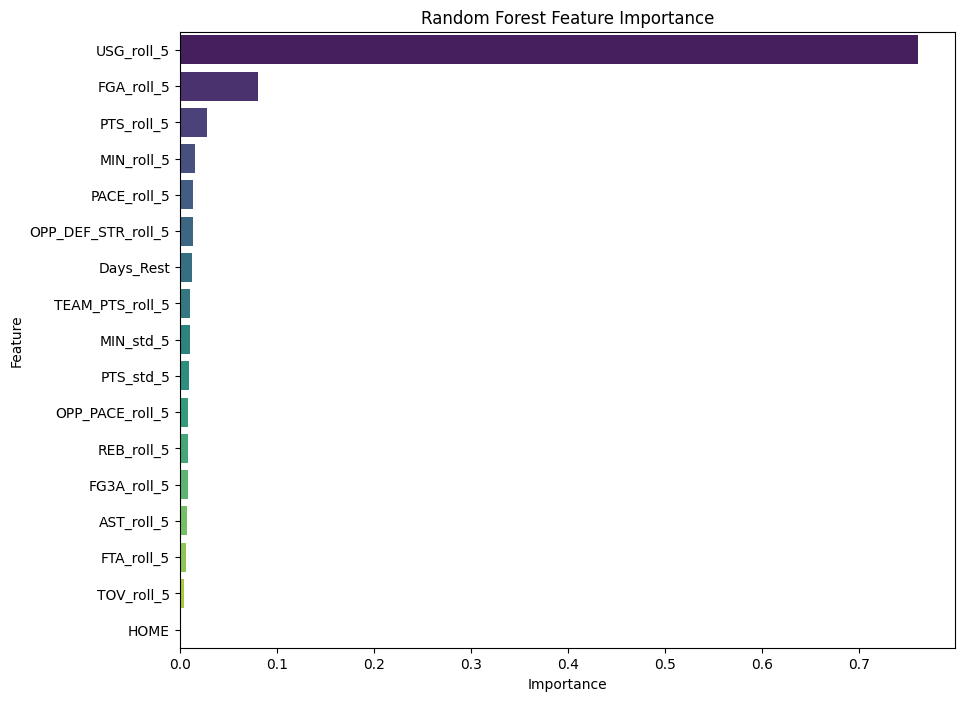

In [17]:
# --- 4. Feature Importance (from Random Forest) ---
print("\n--- Feature Importance (Random Forest Model) ---")
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
# FIX: Assign 'feature' to 'y' and 'hue' to fix the FutureWarning
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df,
    palette='viridis',
    hue='feature',  # Add this
    legend=False    # Add this
)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('all_features_importance.png')
print("Feature importance plot saved as 'all_features_importance.png'")


# --- 5. Actual vs. Predicted Comparison (using the best model) ---
print("\n--- Actual vs. Predicted Scores (from Best Model) ---")
best_predictions = lr_preds # Use LR as it was the best

# Create a new DataFrame for comparison
comparison_df = df_model.loc[y_test.index].copy()
comparison_df['Actual_PTS'] = y_test
comparison_df['Predicted_PTS'] = best_predictions.round(1)
comparison_df['Difference'] = (comparison_df['Actual_PTS'] - comparison_df['Predicted_PTS']).round(1)

display_cols = ['PLAYER_NAME', 'GAME_DATE', 'Actual_PTS', 'Predicted_PTS', 'Difference']

print("\nFirst 10 Games in Test Set (LeBron):")
display(comparison_df[comparison_df['PLAYER_NAME'] == 'LeBron James'][display_cols].head(10))

print("\nModel's 5 Best Predictions (Smallest Difference):")
display(comparison_df.iloc[comparison_df['Difference'].abs().argsort()].head(5)[display_cols])

print("\nModel's 5 Worst Predictions (Largest Difference):")
display(comparison_df.iloc[comparison_df['Difference'].abs().argsort()[::-1]].head(5)[display_cols])